In [494]:
import webbrowser
import pandas as pd
import gspread
import gspread_dataframe as gd
from gspread_dataframe import get_as_dataframe, set_with_dataframe
from oauth2client.service_account import ServiceAccountCredentials # Đọc dữ liệu từ googlesheets
from df2gspread import df2gspread as d2g # Ghi dữ liệu lên googlesheets
from pprint import pprint
from googleapiclient import discovery
import pypyodbc #connect với sql server
import numpy as np #Tính toán (=,-,*,/)
import sqlalchemy #query trực tiếp
import urllib #connect url
import time #
import datetime as dt
import pymssql
import random
import math
import calendar
import warnings
import itertools
warnings.filterwarnings("ignore")
import pygsheets

In [495]:
import matplotlib.pyplot as plt
import seaborn as sns

In [770]:
#connect server
db = pypyodbc.connect("Driver={ODBC Driver 17 for SQL Server};"
                        "Server=103.69.193.246;"
                        "Database=dwh;"
                        "uid=dwh;pwd=F88!23456789")
print('Connected to SQL server: DWH')

Connected to SQL server: DWH


In [497]:
scope = ["https://spreadsheets.google.com/feeds",'https://www.googleapis.com/auth/spreadsheets',"https://www.googleapis.com/auth/drive.file","https://www.googleapis.com/auth/drive"]
credentials = ServiceAccountCredentials.from_json_keyfile_name(r'D:\F88\Python code\Immediate_warning\service_account.json', scope)
gc = gspread.authorize(credentials)

client = pygsheets.authorize(service_account_file=r'D:\F88\Python code\Immediate_warning\service_account.json')

#Lấy ID và truy cập wb Backup
backup_ss_id='1iYODUg3bS0JlRzkuq-cnrVZYXJgcNGAa2Wj7i2McHIc'
backup_wb=gc.open_by_key(backup_ss_id)

#Lấy ID và truy cập wb Warning.Control
control_ssheet_id= '1101WzQvQ897hq4xyjvKHesT4ycx8to7bD9EvLGkcPSQ' 
control_wb=gc.open_by_key(control_ssheet_id)

#Function chuyển sheet thành Data Frame
def to_dataframe(wb_name,sheet_name,data_row,col):
    a=wb_name.worksheet(sheet_name).get_all_values()
    return pd.DataFrame(data=a[data_row:],columns=a[col])

#Funtion update data vào sheet wb_name:tên wb,target_sheet: tên sheet cần update; data:dữ liệu muốn update
def update_data(wb_name,target_sheet,data):
    existing =to_dataframe(wb_name,target_sheet,1,0)
    updated = existing.append(data,sort=False)
    gd.set_with_dataframe(wb_name.worksheet(target_sheet),updated)

# Function ghi đè dữ liệu lên gg sheet
def write_data(wb_name,ws_name,ws_range,data):
    wb_name.values_clear(ws_range)
    sheet=wb_name.worksheet(ws_name)
    set_with_dataframe(sheet,data)
    print('Đã ghi dữ liệu lên sheet '+ ws_name)

#Function backup data các HĐ đã check
def back_up_data(data):
    update_data(backup_wb,'backup',data[['codeno','reason_check','shopcode','year_month']])
    short_list=to_dataframe(control_wb,'short_list',1,0)

In [498]:
# Get writeoff list
writeoff_id = '15r30_u_xE0iUexkUgsbZqcZTy0htmSflCp-uty_1hWA'
writeoff_wb = client.open_by_key(writeoff_id)
write_off_list=writeoff_wb.worksheet_by_title('list').get_as_df()

write_off_list = write_off_list[['write_off_period', 'codeno', 'amount']]
write_off_list.columns = ['write_off_period', 'pawn_code', 'amount']

In [499]:
today=dt.date.today()
y_m= (today+dt.timedelta(days = -1)).strftime('%y%m')
checkdate = (today+dt.timedelta(days = -1)).strftime("%Y-%m-%d")
yearmonth = (today+dt.timedelta(days = -1)).strftime("%Y%m")

In [500]:
# pred_score_id
com_pred_score_id='1101WzQvQ897hq4xyjvKHesT4ycx8to7bD9EvLGkcPSQ'
com_pred_score_wb=gc.open_by_key(com_pred_score_id)
com_pred_score=to_dataframe(com_pred_score_wb,'Predicted_Compliance_Score',1,0)

In [501]:
com_pred_score['ols_pred_score'] = pd.to_numeric(com_pred_score['ols_pred_score'])

In [502]:
com_pred_score['ols_pred_score'].describe()

count    202.000000
mean     288.846535
std       85.857056
min     -581.000000
25%      251.250000
50%      291.500000
75%      334.750000
max      497.000000
Name: ols_pred_score, dtype: float64

In [503]:
#  outliers selection
def lower_outlier_selection(datacolumn):
    sorted(datacolumn)
    Q1, Q3 = np.percentile(datacolumn, [25,75])
    IQR = Q3 - Q1
    lower_range = Q1 - (1.5 * IQR)
#     upper_range = Q3 + (1.5 * IQR)
    return lower_range


In [504]:
# Upper outlier
#  outliers selection
def upper_outlier_selection(datacolumn):
    sorted(datacolumn)
    Q1, Q3 = np.percentile(datacolumn, [25,75])
    IQR = Q3 - Q1
#     lower_range = Q1 - (1.5 * IQR)
    upper_range = Q3 + (1.5 * IQR)
    return upper_range

In [505]:
upper_outlier_pred_score = upper_outlier_selection(com_pred_score['ols_pred_score'])

In [506]:
lower_outlier_pred_score = lower_outlier_selection(com_pred_score['ols_pred_score'])

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         4., 21., 65., 61., 40.,  9.,  1.]),
 array([-581. , -527.1, -473.2, -419.3, -365.4, -311.5, -257.6, -203.7,
        -149.8,  -95.9,  -42. ,   11.9,   65.8,  119.7,  173.6,  227.5,
         281.4,  335.3,  389.2,  443.1,  497. ]),
 <a list of 20 Patch objects>)

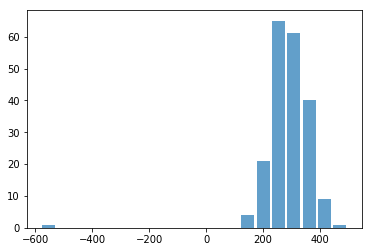

In [507]:
# Điểm tuân thủ dự báo
plt.hist(com_pred_score['ols_pred_score'], bins=20, alpha=0.7, rwidth=0.85)

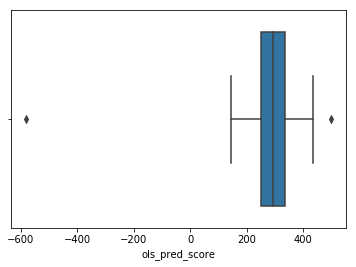

In [508]:
sns.boxplot(com_pred_score['ols_pred_score'])

In [509]:
com_pred_score['ols_pred_score'].describe()

count    202.000000
mean     288.846535
std       85.857056
min     -581.000000
25%      251.250000
50%      291.500000
75%      334.750000
max      497.000000
Name: ols_pred_score, dtype: float64

In [510]:
upper_outlier_pred_score = upper_outlier_selection(com_pred_score['ols_pred_score'])

In [511]:
com_pred_score['sample_selection_rate'] = np.where((com_pred_score['ols_pred_score']>=upper_outlier_pred_score)|(com_pred_score['ols_pred_score']<0), 1,np.where((com_pred_score['ols_pred_score']>=400) & (com_pred_score['ols_pred_score']<upper_outlier_pred_score), 0.5, np.where(((com_pred_score['ols_pred_score']<400) & (com_pred_score['ols_pred_score']> 350))|((com_pred_score['ols_pred_score']<150) & (com_pred_score['ols_pred_score']> 0)),0.3, 0.1)))

In [512]:
com_pred_score.head(5)

,day,shop_age_group,extract_date,shopname,Compliance_risk_Rating,ols_pred_score,shop_age_m,province_name,province_id,province_risk_level,...,avg_number_disbur_pawn_motor_title,avg_number_disbur_pawn_normal_asset,car_title_nums_day_disbur_rate,motor_title_nums_day_disbur_rate,normal_asset_nums_day_disbur_rate,car_title_closed_rate,motor_title_closed_rate,normal_asset_closed_rate,region_id,sample_selection_rate
0,10,running_7-12m,2020-11-10 0:00:00,BLU0159.43 Trần Phú,,243,8,Bạc Liêu,94,4,...,5.6000,1.0000,0.00%,100.00%,20.00%,,1.73%,20.83%,3.0000,0.1
1,10,running_7-12m,2020-11-10 0:00:00,BNH0146.147 Nguyễn Văn Cừ,,375,9,Bắc Ninh,99,3,...,1.3750,1.0000,0.00%,80.00%,30.00%,,3.07%,27.27%,1.0000,0.3
2,10,running_4-6m,2020-11-10 0:00:00,BVU0191.507 Nguyễn An Ninh,,302,5,Bà Rịa - Vũng Tàu,72,3,...,2.2857,,10.00%,70.00%,0.00%,0.00%,3.37%,,3.0000,0.1
3,10,running_more_than_24m,2020-11-10 0:00:00,F88 01 Đội Cấn,,226,38,Hà Nội,29,3,...,1.7500,1.6667,0.00%,80.00%,60.00%,,6.00%,12.50%,1.0000,0.1
4,10,running_13-24m,2020-11-10 0:00:00,F88 106 Tôn Thất Tùng,,245,17,Hà Nội,29,3,...,1.2857,2.3333,10.00%,70.00%,90.00%,25.00%,9.35%,13.82%,1.0000,0.1


In [682]:
# LTV tại thời điểm giải ngân
ltv_result_str ="""Declare @check_date date = '"""+checkdate+"""'
  select CategoryName,CustomerName, ShopName,pawnid, ContractCode,shopcode,
  case when PackageCode like '%NHANH%' then N'Vay nhanh' else N'Vay thường' end package_name,
  (moneyOrg - InsurranceMoney)/MoneyAppraisal ltv_index
  from [dwh].[dbo].[PawnOverdue]
  where CREATED = @check_date
  and FromDate = @check_date"""

In [683]:
ltv_of_pawn = pd.read_sql_query(ltv_result_str, db)

ltv_title = ltv_of_pawn[(ltv_of_pawn['categoryname'] =='Đăng ký xe máy')|(ltv_of_pawn['categoryname'] =='Đăng ký Ô tô')]

check_ltv = ltv_title[ltv_title['ltv_index']>=0.75]

check_ltv['pawn_fraud_group'] = 'HĐ đăng ký có LTV cao'
check_ltv['extract_date'] = checkdate
check_ltv['year_month'] = yearmonth

check_ltv.columns = ['category_name', 'customer', 'shop_name', 'pawnid', 'codeno',
       'shopcode', 'package_name', 'ltv_index', 'pawn_fraud_group',
       'extract_date', 'year_month']

In [684]:
check_ltv = check_ltv[['year_month','extract_date','shop_name','shopcode','customer','codeno','category_name','pawn_fraud_group']]

In [767]:
check_ltv

,year_month,extract_date,shop_name,shopcode,customer,codeno,category_name,pawn_fraud_group
70,202011,2020-11-11,F88 92 Lê Lợi (Hà Đông),HN92LL,Lê Trung Thành,HDCC/HN92LL/2011/168,Đăng ký xe máy,HĐ đăng ký có LTV cao
199,202011,2020-11-11,F88 HCM - 128 Cách Mạng Tháng 8,SG2026,Lê Hào Hùng,HDCC/SG2026/2011/163,Đăng ký xe máy,HĐ đăng ký có LTV cao
210,202011,2020-11-11,F88 HCM - 54H Nguyễn Ảnh Thủ,SG2014,Nguyễn Ngọc Hiền,HDCC/SG2014/2011/171,Đăng ký xe máy,HĐ đăng ký có LTV cao
242,202011,2020-11-11,F88 352 Bạch Mai,HN352BM,Nguyễn Thị Mai,HDCC/HN352BM/2011/177,Đăng ký xe máy,HĐ đăng ký có LTV cao
383,202011,2020-11-11,F88 01 Cầu Tó,HN01CTO,Nguyễn Thị Hà Phương,HDCC/HN01CTO/2011/198,Đăng ký xe máy,HĐ đăng ký có LTV cao
487,202011,2020-11-11,F88 57 Khâm Thiên,HN57KT,Lê Ngọc Long,HDCC/HN57KT/2011/160,Đăng ký xe máy,HĐ đăng ký có LTV cao
505,202011,2020-11-11,F88 46 Nguyễn Chí Thanh,HN46NCT,Ngô Văn Tuấn,HDCC/HN46NCT/2011/153,Đăng ký xe máy,HĐ đăng ký có LTV cao
642,202011,2020-11-11,F88 HCM - 94 Lê Văn Khương,SG2015,NGÔ NGỌC DUNG,HDCC/SG2015/2011/92,Đăng ký xe máy,HĐ đăng ký có LTV cao
677,202011,2020-11-11,F88 52 Lương thế Vinh,HN52LTV,Nguyễn Hoàng Việt,HDCC/HN52LTV/2011/158,Đăng ký xe máy,HĐ đăng ký có LTV cao
811,202011,2020-11-11,F88 624 Minh Khai,HN624MK,Lâm Viết Đăng,HDCC/HN624MK/2011/196,Đăng ký xe máy,HĐ đăng ký có LTV cao


IMAGE

In [685]:
normass_nums_image_standard = 10
title_nums_image_standard = 10

In [775]:
ima_upload_str = """declare @ext_date date = '"""+checkdate+"""'
select  @ext_date extract_date,pa.shopcode, sd.name shopname, pa.CodeNo, cd.NAME category_name, pa.PackageCode, paf.PawnAssetFileID, 
paf.Created, pa.InitTime, le.OpenHour, cus.Name customer
from [dwh].[dbo].pawn pa
left join [dwh].[dbo].PawnAssetFile paf on paf.PawnID = pa.Pawnid
left join [dwh].[dbo].W_CATEGORY_D cd on cd.CODE = pa.CategoryCode
left join [dwh].[dbo].OPEN_CLOSE_CONTRACT_BY_TIME le on le.CodeNo = pa.CodeNo
left join [dwh].[dbo].ShopDetail sd on sd.code = pa.ShopCode
left join [dwh].[dbo].Customer cus on cus.CustomerID = pa.CustomerID
where pa.fromdate = @ext_date
and pa.STATUS in (1,14)
and pa.ShopCode not like '%TEST%'
and pa.ShopCode not like '%HS%'"""

In [776]:
ima_upload = pd.read_sql_query(ima_upload_str,db)

In [777]:
ima_upload.columns

Index(['extract_date', 'shopcode', 'shopname', 'codeno', 'category_name',
       'packagecode', 'pawnassetfileid', 'created', 'inittime', 'openhour',
       'customer'],
      dtype='object')

In [778]:
# image_summ = ima_upload.groupby(['category_name','codeno']).agg({'pawnassetfileid':'count', 'created': ['min', 'max'], 'inittime':'min'})

In [779]:
image_pivot = ima_upload.pivot_table(index=['extract_date', 'shopcode', 'shopname', 'codeno', 'category_name','customer'], values='pawnassetfileid', aggfunc='count').reset_index()

In [780]:
sub1_image_pivot = ima_upload.pivot_table(index=['extract_date', 'shopcode', 'shopname', 'codeno', 'category_name','customer'], values='created', aggfunc='min').reset_index()
sub2_image_pivot = ima_upload.pivot_table(index=['extract_date', 'shopcode', 'shopname', 'codeno', 'category_name','customer'], values='created', aggfunc='max').reset_index()

In [781]:
sub3_image_pivot = ima_upload.pivot_table(index=['extract_date', 'shopcode', 'shopname', 'codeno', 'category_name','customer'], values='openhour', aggfunc='min').reset_index()

In [782]:
sub1_image_pivot.columns = ['extract_date', 'shopcode', 'shopname', 'codeno', 'category_name','customer','min_created']

In [783]:
sub2_image_pivot.columns = ['extract_date', 'shopcode', 'shopname', 'codeno', 'category_name','customer', 'max_created']

In [784]:
sub3_image_pivot.columns

Index(['extract_date', 'shopcode', 'shopname', 'codeno', 'category_name',
       'customer', 'openhour'],
      dtype='object')

In [785]:
sub3_image_pivot.columns = ['extract_date', 'shopcode', 'shopname', 'codeno', 'category_name','customer','openhour']

In [786]:
image_summ = image_pivot.merge(sub1_image_pivot, on = ['extract_date', 'shopcode', 'shopname', 'codeno', 'category_name','customer'], how = 'left')

In [787]:
image_summ.head(5)

,extract_date,shopcode,shopname,codeno,category_name,customer,pawnassetfileid,min_created
0,2020-11-11,1148DL,F88 1148 Đường Láng,HDCC/1148DL/2011/156,Đăng ký xe máy,Lê Hồng Điệp,46,2020-11-11 10:12:34.420
1,2020-11-11,1148DL,F88 1148 Đường Láng,HDCC/1148DL/2011/162,Xe máy,Nguyễn Văn Hà,38,2020-11-11 12:27:40.403
2,2020-11-11,1148DL,F88 1148 Đường Láng,HDCC/1148DL/2011/163,Trang sức,Trần Đức Quang,12,2020-11-11 13:53:07.240
3,2020-11-11,1148DL,F88 1148 Đường Láng,HDCC/1148DL/2011/166,Xe máy,Đinh Văn Tuấn,17,2020-11-11 15:12:16.420
4,2020-11-11,1148DL,F88 1148 Đường Láng,HDCC/1148DL/2011/167,Xe máy,Đoàn Thanh Tùng,20,2020-11-11 18:37:46.000


In [788]:
image_summ = image_summ.merge(sub2_image_pivot, on = ['extract_date', 'shopcode', 'shopname', 'codeno', 'category_name','customer'], how = 'left').merge(sub3_image_pivot, on = ['extract_date', 'shopcode', 'shopname', 'codeno', 'category_name','customer'], how = 'left')

In [789]:
image_summ.head(5)

,extract_date,shopcode,shopname,codeno,category_name,customer,pawnassetfileid,min_created,max_created,openhour
0,2020-11-11,1148DL,F88 1148 Đường Láng,HDCC/1148DL/2011/156,Đăng ký xe máy,Lê Hồng Điệp,46,2020-11-11 10:12:34.420,2020-11-11 11:58:11.753,2020-11-11 10:12:31.337
1,2020-11-11,1148DL,F88 1148 Đường Láng,HDCC/1148DL/2011/162,Xe máy,Nguyễn Văn Hà,38,2020-11-11 12:27:40.403,2020-11-11 12:44:11.857,2020-11-11 12:27:40.363
2,2020-11-11,1148DL,F88 1148 Đường Láng,HDCC/1148DL/2011/163,Trang sức,Trần Đức Quang,12,2020-11-11 13:53:07.240,2020-11-11 17:18:12.977,2020-11-11 13:53:07.143
3,2020-11-11,1148DL,F88 1148 Đường Láng,HDCC/1148DL/2011/166,Xe máy,Đinh Văn Tuấn,17,2020-11-11 15:12:16.420,2020-11-11 15:31:06.163,2020-11-11 15:12:16.363
4,2020-11-11,1148DL,F88 1148 Đường Láng,HDCC/1148DL/2011/167,Xe máy,Đoàn Thanh Tùng,20,2020-11-11 18:37:46.000,2020-11-11 18:54:39.723,2020-11-11 18:37:45.937


In [790]:
image_summ['1stupload_to_create'] = (image_summ['min_created'] - image_summ['openhour']).astype('timedelta64[m]')

In [791]:
image_summ['last_upload_to_create'] = (image_summ['max_created'] - image_summ['openhour']).astype('timedelta64[m]')

In [792]:
title_image = image_summ[(image_summ['category_name'] == 'Đăng ký xe máy')|(image_summ['category_name'] == 'Đăng ký Ô tô')]

In [793]:
normass_image = image_summ[(image_summ['category_name'] != 'Đăng ký xe máy')|(image_summ['category_name'] != 'Đăng ký Ô tô')]

In [794]:
# Số lượng ảnh
title_nums_image_sample = title_image[title_image['pawnassetfileid']<= title_nums_image_standard]

In [795]:
normass_nums_image_sample = normass_image[normass_image['pawnassetfileid']<= normass_nums_image_standard]

In [796]:
title_nums_image_sample

,extract_date,shopcode,shopname,codeno,category_name,customer,pawnassetfileid,min_created,max_created,openhour,1stupload_to_create,last_upload_to_create


In [797]:
check_full_nums_image = title_nums_image_sample.append(normass_nums_image_sample)

['year_month','extract_date','shop_name','shopcode','customer','codeno','category_name','pawn_fraud_group']

In [798]:
check_full_nums_image['year_month'] = yearmonth
check_full_nums_image['pawn_fraud_group'] = 'HĐ upload ít ảnh'

In [799]:
check_full_nums_image.columns = ['extract_date', 'shopcode', 'shop_name', 'codeno', 'category_name',
       'customer', 'pawnassetfileid', 'min_created', 'max_created', 'openhour',
       '1stupload_to_create', 'last_upload_to_create', 'year_month',
       'pawn_fraud_group']

In [800]:
check_full_nums_image = check_full_nums_image[['year_month','extract_date','shop_name','shopcode','customer','codeno','category_name','pawn_fraud_group']]

In [801]:
# image_upload_process
image_upload_process_standard = 120

In [802]:
title_time_process = title_image[title_image['1stupload_to_create'] >image_upload_process_standard]

In [803]:
normass_time_process = normass_image[normass_image['1stupload_to_create'] >image_upload_process_standard]

In [804]:
nums_ima_fully_sample = title_nums_image_sample.append(normass_nums_image_sample)

In [805]:
time_process_fully_sample = title_time_process.append(normass_time_process)

In [806]:
time_process_fully_sample['year_month'] = yearmonth
time_process_fully_sample['pawn_fraud_group'] = 'Thời gian từ lúc tạo HĐ và upload ảnh đầu tiên lớn'

In [807]:
time_process_fully_sample.columns = ['extract_date', 'shopcode', 'shop_name', 'codeno', 'category_name',
       'customer', 'pawnassetfileid', 'min_created', 'max_created', 'openhour',
       '1stupload_to_create', 'last_upload_to_create', 'year_month',
       'pawn_fraud_group']

In [808]:
time_process_fully_sample = time_process_fully_sample[['year_month','extract_date','shop_name','shopcode','customer','codeno','category_name','pawn_fraud_group']]

In [809]:
check_1 = check_full_nums_image.append(time_process_fully_sample)

MỞ NHIỀU HĐ TRONG NGÀY

In [810]:
shop_check_rate = com_pred_score[['shopname','ols_pred_score','sample_selection_rate']]

In [811]:
top_title_str = """Declare @check_date date = '"""+checkdate+"""'
select main.ShopCode, sd.Name shopname, case when main.CategoryCode like '%15%' then N'Đăng ký Ô tô' else N'Đăng ký xe máy' end category_name, 
count(main.Pawnid) nums_created_pawn
from (Select ShopCode, pawnid, CodeNo, CategoryCode, FromDate extract_date
from [dwh].[dbo].Pawn pa
where FromDate = @check_date
and (CategoryCode like '%17%' or CategoryCode like '%15%')
and status not in (11,15,22)) main
left join [dwh].[dbo].ShopDetail sd on sd.code = main.shopcode
group by sd.Name, main.ShopCode, main.CategoryCode"""

In [812]:
top_title = pd.read_sql_query(top_title_str,db)

In [813]:
shop_top_motor_title = top_title[(top_title['category_name'] == 'Đăng ký xe máy') & (top_title['nums_created_pawn']>6)]

In [814]:
shop_top_motor_title

,shopcode,shopname,category_name,nums_created_pawn
1,BPC0151,BPC0151.957 Phú Riềng Đỏ,Đăng ký xe máy,9
15,BTE0184,BTE0184.363A Đoàn Hoàng Minh,Đăng ký xe máy,8
45,SG2042,F88 HCM - 128/1 Nguyễn Ảnh Thủ,Đăng ký xe máy,7
55,DTP0216,DTP0216.12-14 Quốc Lộ 30,Đăng ký xe máy,8
68,BDG0127,BDG0127.89 đường N5,Đăng ký xe máy,8
70,BDG0181,BDG0181.22 Tháng 12,Đăng ký xe máy,7
71,CMU0202,CMU0202.165 Nguyễn Trãi,Đăng ký xe máy,10
114,KGG0225,KGG0225.493 Nguyễn Trung Trực,Đăng ký xe máy,8
134,BDG0193,BDG0193.516 Đại lộ Bình Dương,Đăng ký xe máy,7
135,BDG0227,BDG0227.Tân Phước Khánh,Đăng ký xe máy,7


In [815]:
shop_top_car_title = top_title[(top_title['category_name'] == 'Đăng ký Ô tô') & (top_title['nums_created_pawn']>=3)]

In [816]:
shop_top_motor_title = shop_top_motor_title.merge(shop_check_rate, on = 'shopname', how = 'left')

In [817]:
shop_top_motor_title['sample_selection_rate'] = shop_top_motor_title['sample_selection_rate'].fillna(0.25)

In [818]:
shop_top_motor_title

,shopcode,shopname,category_name,nums_created_pawn,ols_pred_score,sample_selection_rate
0,BPC0151,BPC0151.957 Phú Riềng Đỏ,Đăng ký xe máy,9,334.0,0.10
1,BTE0184,BTE0184.363A Đoàn Hoàng Minh,Đăng ký xe máy,8,296.0,0.10
2,SG2042,F88 HCM - 128/1 Nguyễn Ảnh Thủ,Đăng ký xe máy,7,307.0,0.10
3,DTP0216,DTP0216.12-14 Quốc Lộ 30,Đăng ký xe máy,8,NaN,0.25
4,BDG0127,BDG0127.89 đường N5,Đăng ký xe máy,8,264.0,0.10
5,BDG0181,BDG0181.22 Tháng 12,Đăng ký xe máy,7,181.0,0.10
6,CMU0202,CMU0202.165 Nguyễn Trãi,Đăng ký xe máy,10,191.0,0.10
7,KGG0225,KGG0225.493 Nguyễn Trung Trực,Đăng ký xe máy,8,NaN,0.25
8,BDG0193,BDG0193.516 Đại lộ Bình Dương,Đăng ký xe máy,7,153.0,0.10
9,BDG0227,BDG0227.Tân Phước Khánh,Đăng ký xe máy,7,NaN,0.25


In [819]:
def pawn_infor_dkxm(date, shop):
    pawn_created_infor_str = """Declare @check_date date = '"""+date+"""'
    Declare @shop_code varchar(60) = '"""+shop+"""'
    Select pa.ShopCode, cus.Name customer,sd.Name shopname,pa.CodeNo, case when CategoryCode like '%15%' then N'Đăng ký Ô tô' else N'Đăng ký xe máy' end category_name, FromDate extract_date
from [dwh].[dbo].Pawn pa
left join [dwh].[dbo].shopdetail sd on sd.code = pa.shopcode
left join [dwh].[dbo].Customer cus on cus.[CustomerID] = pa.CustomerID
where pa.FromDate = @check_date
and pa.shopcode = @shop_code
and pa.CategoryCode like '%17%'
and pa.status not in (11,15,22)"""
    pawn_created = pd.read_sql_query(pawn_created_infor_str, db)
    return pawn_created

In [820]:
motor_title_top_shop = pd.DataFrame(columns=['year_month','extract_date','shop_name','shopcode','customer','codeno','category_name','pawn_fraud_group'])

In [821]:
shop_top_motor_title['shopcode']

0     BPC0151
1     BTE0184
2      SG2042
3     DTP0216
4     BDG0127
5     BDG0181
6     CMU0202
7     KGG0225
8     BDG0193
9     BDG0227
10    TNH0174
Name: shopcode, dtype: object

In [822]:
for i in range(0, len(shop_top_motor_title['shopcode'])):
#     i_quote = "'"+shop_top_motor_title['shopcode'][i]+"'"
    created_raw_data = pawn_infor_dkxm(checkdate,shop_top_motor_title['shopcode'][i])
    created_raw_data['year_month'] = yearmonth
    created_raw_data['pawn_fraud_group'] = 'PGD mở nhiều HĐ trong ngày'
    created_raw_data.columns = ['shopcode', 'customer', 'shop_name', 'codeno', 'category_name','extract_date', 'year_month', 'pawn_fraud_group']
    created_raw_data = created_raw_data[['year_month','extract_date','shop_name','shopcode','customer','codeno','category_name','pawn_fraud_group']]
    check_sample = created_raw_data.sample(frac=shop_top_motor_title[shop_top_motor_title['shopcode']==shop_top_motor_title['shopcode'][i]]['sample_selection_rate'], replace=True, random_state=1)
    motor_title_top_shop = motor_title_top_shop.append(check_sample)

In [823]:
motor_title_top_shop

,year_month,extract_date,shop_name,shopcode,customer,codeno,category_name,pawn_fraud_group
5,202011,2020-11-11,BPC0151.957 Phú Riềng Đỏ,BPC0151,None,HDCC/BPC0151/2011/244,Đăng ký xe máy,PGD mở nhiều HĐ trong ngày
5,202011,2020-11-11,BTE0184.363A Đoàn Hoàng Minh,BTE0184,None,HDCC/BTE0184/2011/232,Đăng ký xe máy,PGD mở nhiều HĐ trong ngày
5,202011,2020-11-11,F88 HCM - 128/1 Nguyễn Ảnh Thủ,SG2042,LÊ VŨ,HDCC/SG2042/2011/185,Đăng ký xe máy,PGD mở nhiều HĐ trong ngày
5,202011,2020-11-11,DTP0216.12-14 Quốc Lộ 30,DTP0216,None,HDCC/DTP0216/2011/157,Đăng ký xe máy,PGD mở nhiều HĐ trong ngày
3,202011,2020-11-11,DTP0216.12-14 Quốc Lộ 30,DTP0216,None,HDCC/DTP0216/2011/146,Đăng ký xe máy,PGD mở nhiều HĐ trong ngày
5,202011,2020-11-11,BDG0127.89 đường N5,BDG0127,None,HDCC/BDG0127/2011/170,Đăng ký xe máy,PGD mở nhiều HĐ trong ngày
5,202011,2020-11-11,BDG0181.22 Tháng 12,BDG0181,BÙI VĂN HIỂN,HDCC/BDG0181/2011/180,Đăng ký xe máy,PGD mở nhiều HĐ trong ngày
5,202011,2020-11-11,CMU0202.165 Nguyễn Trãi,CMU0202,HUỲNH THỊ CẨM TÚ,HDCC/CMU0202/2011/244,Đăng ký xe máy,PGD mở nhiều HĐ trong ngày
5,202011,2020-11-11,KGG0225.493 Nguyễn Trung Trực,KGG0225,None,HDCC/KGG0225/2011/209,Đăng ký xe máy,PGD mở nhiều HĐ trong ngày
3,202011,2020-11-11,KGG0225.493 Nguyễn Trung Trực,KGG0225,None,HDCC/KGG0225/2011/215,Đăng ký xe máy,PGD mở nhiều HĐ trong ngày


In [824]:
shop_top_car_title = shop_top_car_title.merge(shop_check_rate, on = 'shopname', how = 'left')

In [825]:
# shop_top_car_title['sample_selection_rate'] = shop_top_car_title['sample_selection_rate'].fillna(0.5)
shop_top_car_title['sample_selection_rate'] = 1

In [826]:
def pawn_infor_dkot(date, shop):
    dkot_pawn_created_infor_str = """Declare @check_date date = '"""+date+"""'
    Declare @shop_code varchar(60) = '"""+shop+"""'
    Select pa.ShopCode, cus.Name customer,sd.Name shopname,pa.CodeNo, case when CategoryCode like '%15%' then N'Đăng ký Ô tô' else N'Đăng ký xe máy' end category_name, FromDate extract_date
from [dwh].[dbo].Pawn pa
left join [dwh].[dbo].shopdetail sd on sd.code = pa.shopcode
left join [dwh].[dbo].Customer cus on cus.[CustomerID] = pa.CustomerID
where pa.FromDate = @check_date
and pa.shopcode = @shop_code
and pa.CategoryCode like '%15%'
and pa.status not in (11,15,22)"""
    dkot_pawn_created = pd.read_sql_query(dkot_pawn_created_infor_str, db)
    return dkot_pawn_created

In [827]:
car_title_top_shop = pd.DataFrame(columns=['year_month','extract_date','shop_name','shopcode','customer','codeno','category_name','pawn_fraud_group'])

In [828]:
for i in range(0, len(shop_top_car_title['shopcode'])):
#     i_quote = "'"+shop_top_motor_title['shopcode'][i]+"'"
    dkot_created_raw_data = pawn_infor_dkot(checkdate,shop_top_car_title['shopcode'][i])
    dkot_created_raw_data['year_month'] = yearmonth
    dkot_created_raw_data['pawn_fraud_group'] = 'PGD mở nhiều HĐ trong ngày'
    dkot_created_raw_data.columns = ['shopcode', 'customer', 'shop_name', 'codeno', 'category_name','extract_date', 'year_month', 'pawn_fraud_group']
    dkot_created_raw_data = dkot_created_raw_data[['year_month','extract_date','shop_name','shopcode','customer','codeno','category_name','pawn_fraud_group']]
    dkot_check_sample = dkot_created_raw_data.sample(frac=shop_top_car_title[shop_top_car_title['shopcode']==shop_top_car_title['shopcode'][i]]['sample_selection_rate'], replace=True, random_state=1)
    car_title_top_shop = car_title_top_shop.append(dkot_check_sample)

In [829]:
car_title_top_shop

,year_month,extract_date,shop_name,shopcode,customer,codeno,category_name,pawn_fraud_group


In [830]:
check_2 = motor_title_top_shop.append(car_title_top_shop)

In [831]:
check_2

,year_month,extract_date,shop_name,shopcode,customer,codeno,category_name,pawn_fraud_group
5,202011,2020-11-11,BPC0151.957 Phú Riềng Đỏ,BPC0151,None,HDCC/BPC0151/2011/244,Đăng ký xe máy,PGD mở nhiều HĐ trong ngày
5,202011,2020-11-11,BTE0184.363A Đoàn Hoàng Minh,BTE0184,None,HDCC/BTE0184/2011/232,Đăng ký xe máy,PGD mở nhiều HĐ trong ngày
5,202011,2020-11-11,F88 HCM - 128/1 Nguyễn Ảnh Thủ,SG2042,LÊ VŨ,HDCC/SG2042/2011/185,Đăng ký xe máy,PGD mở nhiều HĐ trong ngày
5,202011,2020-11-11,DTP0216.12-14 Quốc Lộ 30,DTP0216,None,HDCC/DTP0216/2011/157,Đăng ký xe máy,PGD mở nhiều HĐ trong ngày
3,202011,2020-11-11,DTP0216.12-14 Quốc Lộ 30,DTP0216,None,HDCC/DTP0216/2011/146,Đăng ký xe máy,PGD mở nhiều HĐ trong ngày
5,202011,2020-11-11,BDG0127.89 đường N5,BDG0127,None,HDCC/BDG0127/2011/170,Đăng ký xe máy,PGD mở nhiều HĐ trong ngày
5,202011,2020-11-11,BDG0181.22 Tháng 12,BDG0181,BÙI VĂN HIỂN,HDCC/BDG0181/2011/180,Đăng ký xe máy,PGD mở nhiều HĐ trong ngày
5,202011,2020-11-11,CMU0202.165 Nguyễn Trãi,CMU0202,HUỲNH THỊ CẨM TÚ,HDCC/CMU0202/2011/244,Đăng ký xe máy,PGD mở nhiều HĐ trong ngày
5,202011,2020-11-11,KGG0225.493 Nguyễn Trung Trực,KGG0225,None,HDCC/KGG0225/2011/209,Đăng ký xe máy,PGD mở nhiều HĐ trong ngày
3,202011,2020-11-11,KGG0225.493 Nguyễn Trung Trực,KGG0225,None,HDCC/KGG0225/2011/215,Đăng ký xe máy,PGD mở nhiều HĐ trong ngày


HĐ LIMIT

In [832]:
exceed_title_str="""Declare @ext_date date= '"""+checkdate+"""' 
select po.created extract_date, 'Đăng ký xe máy' categoryname,po.tuoino,po.ShopCode,ShopName,po.CustomerID,po.customername,po.PawnID,po.ContractCode,po.FromDate, pa.closedate,ri.codeno
from [dwh].[dbo].PawnOverdue po 
left join [dwh].[dbo].Pawn pa on pa.pawnid = po.pawnid
left join (select * from [dwh].[dbo].pawn where CategoryCode like N'%17%' and STATUS =1) ri on(po.CustomerID=ri.CustomerID and po.fromdate=ri.closedate) 
left join (select customerid, count(pawnid) active_pawn from [dwh].[dbo].pawnoverdue where created=@ext_date and CategoryName like N'%Đăng ký xe máy%' group by customerid) po2 on po2.customerid=po.customerid  
where categoryname like N'%Đăng ký xe máy%' 
and po.ShopCode not like N'%TEST%' 
and po.ShopCode not like N'%HS%' 
and po.created=@ext_date 
and active_pawn>1 order by CustomerID """

In [774]:
exceed_title=pd.read_sql_query(exceed_title_str,db)

In [745]:
write_off_list.columns

Index(['write_off_period', 'pawn_code', 'amount'], dtype='object')

In [746]:
exceed_title = exceed_title.merge(write_off_list, left_on = 'contractcode', right_on='pawn_code', how = 'left')

In [747]:
exceed_title = exceed_title[exceed_title['pawn_code'].isnull() == True]

In [748]:
exceed_title = exceed_title[exceed_title['tuoino']<=90]

In [749]:
except_customer_list = list(exceed_title[exceed_title['codeno'].isnull() == False]['customername'].unique())

In [750]:
except_cus_dict = {'key':except_customer_list}

In [751]:
except_cus_table = pd.DataFrame.from_dict(except_cus_dict)

In [752]:
exceed_title = exceed_title.merge(except_cus_table, left_on='customername', right_on='key', how = 'left')

In [753]:
exceed_title = exceed_title[exceed_title['key'].isnull() == True]

In [754]:
check_shop_list = list(exceed_title['shopname'].unique())

In [755]:
check_shop_dict = {'shopname':check_shop_list}

In [756]:
check_shop_table = pd.DataFrame.from_dict(check_shop_dict)

In [757]:
check_shop_table = check_shop_table.merge(shop_check_rate, on = 'shopname', how = 'left')

In [758]:
check_3 = pd.DataFrame(columns=['extract_date', 'categoryname', 'tuoino', 'shopcode', 'shopname',
       'customerid', 'customername', 'pawnid', 'contractcode', 'fromdate',
       'closedate', 'codeno', 'write_off_period', 'pawn_code', 'amount'])

In [759]:
# for i in range(0, len(check_shop_table['shopname'])):
#     sub_exceed_raw = exceed_title[exceed_title['shopname'] == check_shop_table['shopname'][i]]
#     sub_exceed_raw['year_month'] = y_m
#     sub_exceed_raw['pawn_fraud_group'] = 'KH có 2 HĐ active'
# #     sub_exceed_raw.columns = ['shopcode', 'customer', 'shop_name', 'codeno', 'category_name','extract_date', 'year_month', 'pawn_fraud_group']
# #     sub_exceed_raw = sub_exceed_raw[['year_month','extract_date','shop_name','shopcode','customer','codeno','category_name','pawn_fraud_group']]
# #     sub_check_table = sub_exceed_raw.sample(frac=check_shop_table[check_shop_table['shopname']==check_shop_table['shopname'][i]]['sample_selection_rate'], replace=True, random_state=1)
# #     check_3 = check_3.append(sub_check_table)

In [760]:
exceed_title = exceed_title.merge(shop_check_rate, on = 'shopname', how = 'left')

In [772]:
# exceed_title.sort_values(by = ['customername','sample_selection_rate'], ascending=(True,False))

In [762]:
check_1.columns

Index(['year_month', 'extract_date', 'shop_name', 'shopcode', 'customer',
       'codeno', 'category_name', 'pawn_fraud_group'],
      dtype='object')

In [763]:
check_2.columns

Index(['year_month', 'extract_date', 'shop_name', 'shopcode', 'customer',
       'codeno', 'category_name', 'pawn_fraud_group'],
      dtype='object')

In [833]:
full_check = check_ltv.append(check_1).append(check_2)

In [834]:
full_check['codeno'].count()

35

In [835]:
full_check

,year_month,extract_date,shop_name,shopcode,customer,codeno,category_name,pawn_fraud_group
70,202011,2020-11-11,F88 92 Lê Lợi (Hà Đông),HN92LL,Lê Trung Thành,HDCC/HN92LL/2011/168,Đăng ký xe máy,HĐ đăng ký có LTV cao
199,202011,2020-11-11,F88 HCM - 128 Cách Mạng Tháng 8,SG2026,Lê Hào Hùng,HDCC/SG2026/2011/163,Đăng ký xe máy,HĐ đăng ký có LTV cao
210,202011,2020-11-11,F88 HCM - 54H Nguyễn Ảnh Thủ,SG2014,Nguyễn Ngọc Hiền,HDCC/SG2014/2011/171,Đăng ký xe máy,HĐ đăng ký có LTV cao
242,202011,2020-11-11,F88 352 Bạch Mai,HN352BM,Nguyễn Thị Mai,HDCC/HN352BM/2011/177,Đăng ký xe máy,HĐ đăng ký có LTV cao
383,202011,2020-11-11,F88 01 Cầu Tó,HN01CTO,Nguyễn Thị Hà Phương,HDCC/HN01CTO/2011/198,Đăng ký xe máy,HĐ đăng ký có LTV cao
487,202011,2020-11-11,F88 57 Khâm Thiên,HN57KT,Lê Ngọc Long,HDCC/HN57KT/2011/160,Đăng ký xe máy,HĐ đăng ký có LTV cao
505,202011,2020-11-11,F88 46 Nguyễn Chí Thanh,HN46NCT,Ngô Văn Tuấn,HDCC/HN46NCT/2011/153,Đăng ký xe máy,HĐ đăng ký có LTV cao
642,202011,2020-11-11,F88 HCM - 94 Lê Văn Khương,SG2015,NGÔ NGỌC DUNG,HDCC/SG2015/2011/92,Đăng ký xe máy,HĐ đăng ký có LTV cao
677,202011,2020-11-11,F88 52 Lương thế Vinh,HN52LTV,Nguyễn Hoàng Việt,HDCC/HN52LTV/2011/158,Đăng ký xe máy,HĐ đăng ký có LTV cao
811,202011,2020-11-11,F88 624 Minh Khai,HN624MK,Lâm Viết Đăng,HDCC/HN624MK/2011/196,Đăng ký xe máy,HĐ đăng ký có LTV cao


In [836]:
full_check['risk_type'] = 'Tuân thủ'

In [837]:
# Update
update_data(control_wb,'Checking',full_check)